# **Introduction**

Des études ont montré que la pratique régulière de la course à pied permet d'abaisser la [pression artérielle](https://www.themanual.com/fitness/how-to-lower-blood-pressure/) et la fréquence cardiaque au repos, d'améliorer le contrôle de la glycémie, de réduire les taux de triglycérides et de [cholestérol](https://www.themanual.com/fitness/how-to-lower-cholesterol/), ainsi que le tour de taille et le pourcentage de graisse corporelle. L'amélioration de ces marqueurs de santé peut réduire le risque de maladie et aider à se sentir globalement en meilleure santé.

En tant que développeur de logiciels, je passe la plupart de mon temps assis devant un ordinateur au travail ou à l'université, ce mode de vie sédentaire a eu un impact négatif sur ma santé globale, je devenais de moins en moins productif, je m'essoufflais facilement et j'avais du mal à supporter les activités intenses. J'ai alors décidé de prendre soin de moi et de commencer à courir régulièrement en **juillet 2021** et depuis environ un an, l'application que j'utilise ([Adidas Running](https://www.runtastic.com/)) collecte les données de mes entraînements.

Ce projet a pour but de visualiser et d'analyser mes progrès durant cette période afin de découvrir mais aussi de comprendre comment certains facteurs ont influencé mes performances et aussi comment je pourrais améliorer ou adapter mon entraînement pour être capable de courir un **marathon de 40km**.


# **Objectif**

Je souhaite faire parler mes données, pour cela je vais commencer par me poser des questions générales afin d'orienter mon analyse et ma recherche, l'objectif général est de répondre aux questions suivantes :

- Quel jour de la semaine est-ce que je cours le plus ?
- La température influence-t-elle mes performances ?
- Quel est le meilleur moment pour courir ?
- Ma vitesse moyenne a-t-elle augmenté avec le temps ?
- Combien de temps ai-je couru au total ?
- Combien de kilomètres ai-je parcourus au total ?
- Combien de calories ai-je brûlé au total ?

À partir de là, créez un modèle qui pourrait m'aider à prédire mes performances futures sur la base de toutes les données recueillies.

## 1. **Statistique Descriptive**

### **1.1 Nettoyage et mise en forme des données**

L'objectif du nettoyage des données est de fixer toutes les données qui sont incorrectes, inexactes, incomplètes, mal formatées, dupliquées, ou même sans rapport avec l'objectif de l'ensemble des données. 

Les données exportées de Adidas running sont séparées en plusieurs fichiers et chaque fichier comprend un uuid et la date de l'activité sportive dans le nom du fichier, les mêmes informations sont incluses dans le fichier au format json. 

Pour faciliter le traitement, je ne garderai que l'uuid comme nom de fichier pour faciliter la liaison avec les autres données (gps et élévation).

In [25]:
!pip install pandas numpy matplotlib seaborn calmap researchpy

  Using cached researchpy-0.3.5-py3-none-any.whl (33 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 424.2 kB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)


In [520]:
import fnmatch
import shutil
import re
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import researchpy as rp
import seaborn as sns

colors = {
    "black": "#000",
    "white": "#fff",
    "gray": {50: "#f9fafb", 100: "#f3f4f6", 200: "#e5e7eb", 300: "#d1d5db", 400: "#9ca3af", 500: "#6b7280", 600: "#4b5563", 700: "#374151",800: "#1f2937",900: "#111827"},
    "red": {50: "#fef2f2",100: "#fee2e2",200: "#fecaca",300: "#fca5a5",400: "#f87171",500: "#ef4444",600: "#dc2626",700: "#b91c1c",800: "#991b1b",900: "#7f1d1d"},
    "orange": {50: "#fff7ed",100: "#ffedd5",200: "#fed7aa",300: "#fdba74",400: "#fb923c",500: "#f97316",600: "#ea580c",700: "#c2410c",800: "#9a3412",900: "#7c2d12"},
    "blue": {50: "#eff6ff",100: "#dbeafe",200: "#bfdbfe",300: "#93c5fd",400: "#60a5fa",500: "#3b82f6",600: "#2563eb",700: "#1d4ed8",800: "#1e40af",900: "#1e3a8a"},
}

#### 1.1.1 Aggration des données

In [521]:
def formatDatasetFilename(source: str, destination: str, extension: str = 'json') -> list :
    formatedFilenames = [];
    shutil.rmtree(destination, ignore_errors=True)
    os.mkdir(destination)

    for file in os.listdir(source):
        if fnmatch.fnmatch(file, f'*.{extension}'):

            # removing datetime from original filename
            filename = os.path.join(destination, re.sub("^(.*?)UTC_", "", file))
            shutil.copy(os.path.join(source, file), filename)
            formatedFilenames.append(filename)
    
    return formatedFilenames;

sessions = formatDatasetFilename('./dataset/Sport-sessions', './data/sessions');
gps = formatDatasetFilename('./dataset/Sport-sessions/GPS-data', './data/gps', extension='gpx');
elevations = formatDatasetFilename('./dataset/Sport-sessions/Elevation-data', './data/elevations')

# traitement et aggregation des fichiers json
sessions_data = []
for session in sessions:
    with open(session, 'r') as f:
        sessions_data.append(json.load(f))

# filtre uniquement les sessions de course à pieds
sessions_data = list(filter(lambda session: session['sport_type_id'] == '1', sessions_data))

#### 1.1.2 Normalisation des variables

In [522]:
# conversion du fomration unix timestamp en datatime
def timestampToDatetime(session: dict, fields: list) -> None :
    for field in fields:
        timestamp = int(session[field]) / 1000
        timezone = dt.timezone(dt.timedelta(seconds=7200)) # UTC+2
        session[field] = dt.datetime.fromtimestamp(timestamp, tz=timezone)

# formalisation des données
for session in sessions_data:
    session['distance'] = session['distance'] / 1000.0 #  de mètre en kilomètre
    session['duration'] = round((session['duration'] / 1000) / 60, 2) # durée en minutes
    session['max_speed'] = round(float(session['max_speed']), 2)
    session['average_speed'] = round(float(session['average_speed']), 2)
    session['elevation_loss'] = session['elevation_loss'] * -1 # perte d'élévation négatif
    session['elevation'] = session['elevation_gain'] + session['elevation_loss'] # élévation total
    timestampToDatetime(session,['start_time', 'end_time', 'created_at', 'updated_at'])
    

## creation du dateframe
sessions_df = pd.DataFrame(sessions_data)
sessions_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype                    
---  ------                      --------------  -----                    
 0   start_time                  106 non-null    datetime64[ns, UTC+02:00]
 1   end_time                    106 non-null    datetime64[ns, UTC+02:00]
 2   created_at                  106 non-null    datetime64[ns, UTC+02:00]
 3   updated_at                  106 non-null    datetime64[ns, UTC+02:00]
 4   start_time_timezone_offset  106 non-null    int64                    
 5   end_time_timezone_offset    106 non-null    int64                    
 6   distance                    106 non-null    float64                  
 7   duration                    106 non-null    float64                  
 8   elevation_gain              106 non-null    int64                    
 9   elevation_loss              106 non-null    int64                

In [523]:
## formalisation du type de donnée
sessions_df['longitude'] = sessions_df['longitude'].astype('float64')
sessions_df['latitude'] = sessions_df['latitude'].astype('float64')
sessions_df['manual'] = sessions_df['manual'].astype('bool')
sessions_df['edited'] = sessions_df['edited'].astype('bool')
sessions_df['indoor'] = sessions_df['indoor'].astype('bool')

#### 1.1.3 Nouvelles variables dérivées

In [524]:
# nouvelle variables pour faciliter le traitement
sessions_df['year'] = sessions_df.start_time.dt.year
sessions_df['month'] = sessions_df.start_time.dt.month
sessions_df['weekday'] = sessions_df.start_time.dt.day_name()
sessions_df['created_at'] = sessions_df.start_time.dt.date
sessions_df['weekday_number'] = sessions_df.start_time.dt.weekday

sessions_df['weekday'] = sessions_df['weekday'].astype('category');

# les données relative à l'année 2021 et au delà
sessions_df = sessions_df[sessions_df['created_at'] >= dt.date(2021, 1, 1)]

### **1.2 regroupement, paramètres de tendance central et dispersion**

#### 1.2.1 regroupement de données

la série statitisque est multi-variées, mais il s'agit de données relatives à une activité sportive notamment la course à pieds, le regroupement par classe peut donc se faire en fonction des kilomètres parcours ou durée des sessions

Rappelons :
* la détermination du nombre de classe avec la formule de racine carrée $k = \sqrt{n}$
* la détermination du milieu de classe : $x_{i} = \left(\frac{a + b}{2}\right)$

In [525]:
n = sessions_df['distance'].count()
vmax = sessions_df['distance'].max()
vmin = sessions_df['distance'].min()
k = round(math.sqrt(n))

Nous avons un échantillon de **{{n}}** observations, la plus petite étant **{{vmin}} km** et la plus grande **{{vmax}} km**, à regourper en **{{k}}** classes

In [526]:
bins = np.histogram_bin_edges(sessions_df['distance'], bins='sqrt')
bins_interval = pd.interval_range(vmin - 0.1, vmax + 0.1, periods=k, name='classes', closed='right')
bins_interval = pd.IntervalIndex([
    pd.Interval(round(i.left,3), round(i.right,3), 'both' if i == len(bins_interval) else i.closed)
    for i in bins_interval
])

xi = list(map(lambda x: round(x, 3), bins_interval.mid.to_list()))

ni = sessions_df['distance'].groupby(pd.cut(sessions_df["distance"], bins_interval)).count()
Ni = ni.cumsum()
nixi = np.multiply(ni, xi)

stats = pd.DataFrame({"ni": ni, "y": y, "Ni": Fi, "xi": xi, "nixi": nixi})
print(stats)

                  ni      y  Ni      xi     nixi
(0.587, 2.539]    14   0.00  14   1.563   21.882
(2.539, 4.492]    17   3.98  31   3.516   59.772
(4.492, 6.444]    41   0.00  72   5.468  224.188
(6.444, 8.397]     4   7.88  76   7.421   29.684
(8.397, 10.349]    8  36.77  84   9.373   74.984
(10.349, 12.301]   3  47.67  87  11.325   33.975
(12.301, 14.254]   0  53.92  87  13.277    0.000
(14.254, 16.206]   3  29.38  90  15.230   45.690
(16.206, 18.159]   0  35.24  90  17.182    0.000
(18.159, 20.111]   2  19.73  92  19.135   38.270


#### 1.2.2 Distrubtions des fréquences

Distribution des fréquences des distances parcourues

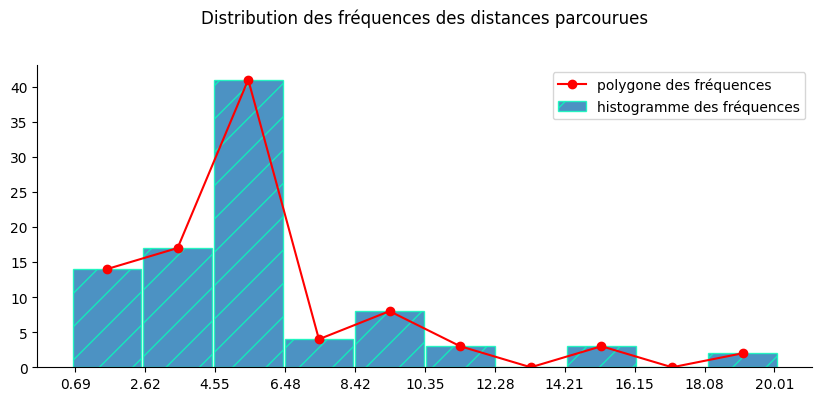

In [527]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Distribution des fréquences des distances parcourues")
plt.bar(xi, ni, width=1.9, hatch="/", edgecolor="#05FFBA", alpha=0.8, label="histogramme des fréquences")
plt.plot(xi, ni, color='red', marker='o', linestyle='-', label="polygone des fréquences")
plt.xticks(bins);
plt.legend();
plt.show();

Distribution des fréquences cumulés des distances parcourues

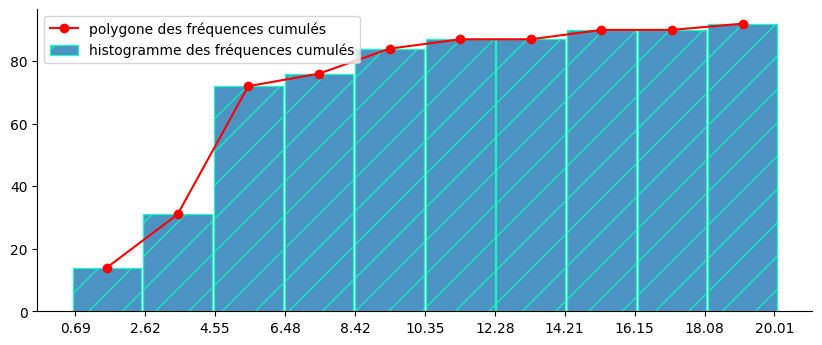

In [528]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(xi, Ni, width=1.9, hatch="/", edgecolor="#05FFBA", alpha=0.8, label="histogramme des fréquences cumulés")
plt.plot(xi, Ni, color='red', marker='o', linestyle='-', label="polygone des fréquences cumulés")
plt.xticks(bins);
plt.legend();
plt.show();

#### 1.2.2 la distance moyenne parcourue 

$\overline{x} = \frac{1}{n} \sum_{i = 1}^{k} n_{i}x_{i}$

In [529]:
mean = round(nixi.sum() / n, 3)

la distance moyenne pour toutes les sessions est **{{mean}} km**.

#### 1.2.3 la distance la plus parcourue

$Mo = a_{i} + h_{i}\left(\frac{\Delta_{1}}{\Delta_{1} + \Delta_{2}}\right)$

avec $\Delta_{1} = (n_{i} − n_{i} − 1)$ et $\Delta_{2} = (n_{i} - n_{i} + 1)$

In [530]:
modal_interval = stats['ni'].idxmax()
modal_class_index = stats.index.get_loc(modal_interval)
modal_class = stats.iloc[modal_class_index];

modal_a = modal_interval.left
modal_h = modal_interval.right - modal_interval.left

delta1 = modal_class.ni - stats.iloc[modal_class_index - 1].ni
delta2 = modal_class.ni - stats.iloc[modal_class_index + 2].ni

mo = round(a + h * (delta1 / (delta1 + delta2)), 3)

l'observation modale par extrapolation est **{{mo}} km**, c'est à dire la distance la plus souvent parcourue 

#### 1.2.4 la médiane

$Me = a_{i} + h_{i}\left(\frac{\frac{n}{2} - N_{i - 1}}{n_{i}}\right)$

In [531]:
median_index = round(n/2);
median_interval = stats[stats['Ni'] >= median_index]['Ni'].idxmin()
median_class_index = stats.index.get_loc(median_interval);
median_class = stats.iloc[modal_class_index]

median_a = median_interval.left
median_h = median_interval.right - median_interval.left

median = round(median_a + median_h * (median_index - stats.iloc[median_class_index - 1].Ni))

l'observation médianne par extrapolation de la distribution est la **{{median}}ème** observation

#### 1.2.5 la variance e t écart type


$S^{2} = \frac{1}{n}\sum_{i=1}^{n}n_{i}\left(x_{i} - \overline{X}\right)^{2}$

$S = \sqrt{S^{2}}$

$CV = \frac{S}{\overline{x}}$

In [532]:
stats['xi - X'] = stats['xi'] - mean
stats['(xi - X)^2'] = stats['xi - X'] * stats['xi - X'] 
stats['ni(x - X)^2'] = stats['ni'] * stats['(xi - X)^2']

variance = round(stats['ni(x - X)^2'].sum() / n, 3)
S = round(math.sqrt(variance), 3)
cv = round(S / mean, 2)

la variance de la distribution est **{{variance}} $km^{2}$**, avec un écart type de **{{S}}km**, 

le coéfficient de variation est **{{cv}}** > 0.17, la série est donc fortement dispersée, c'est-à-dire que les distances sont moins concentrées autour de la moyenne.

### 1.2 Corrélations

#### 1.2.1 distances et (calories,  durées et nombre de pas)

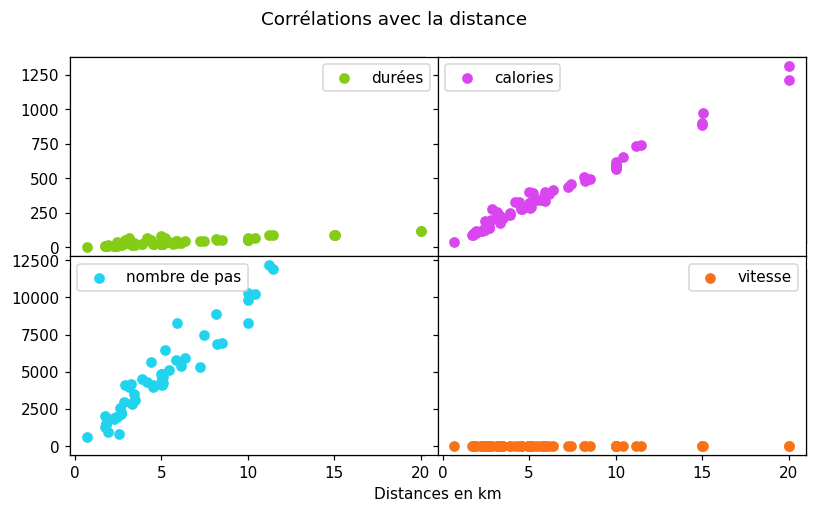

In [591]:
distances_df = sessions_df[
    ['duration', 'distance', 'temperature', 'calories', 'max_speed', 'total_steps']
].sort_values(by="distance")

fig, axs = plt.subplots(2, 2, figsize=(8,5), dpi=110, tight_layout=True)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Distances en km")

fig.suptitle('Corrélations avec la distance')

ax1.scatter(distances_df['distance'], distances_df['duration'], color="#84cc16", label="durées")
ax2.scatter(distances_df['distance'], distances_df['calories'], color="#d946ef", label="calories")
ax3.scatter(distances_df['distance'], distances_df['total_steps'], color="#22d3ee", label="nombre de pas")
ax4.scatter(distances_df['distance'], distances_df['max_speed'], color="#f97316", label="vitesse")

ax2.legend(); ax1.legend(); ax3.legend(); ax4.legend()

for ax in axs.flat:
    ax.xaxis.set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.margins(-0.4, 0.0)
    ax.label_outer()

#### 1.2.3 distances et tout les autres variables

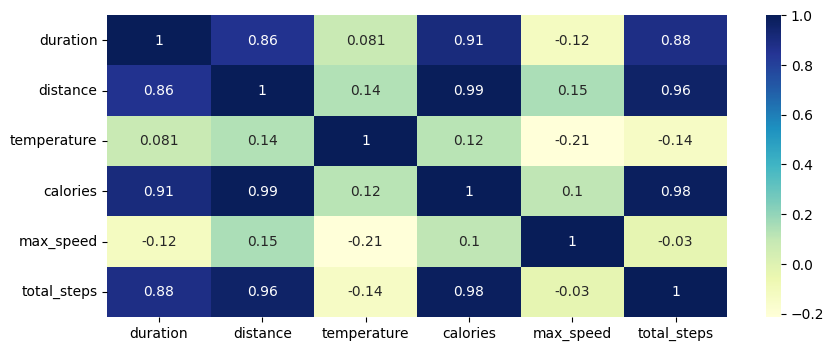

In [549]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.heatmap(distances_df.corr(), cmap="YlGnBu", annot=True);

### 1.3 Visualisation des données à l'aide de graphiques

### Sport Session Frequency 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


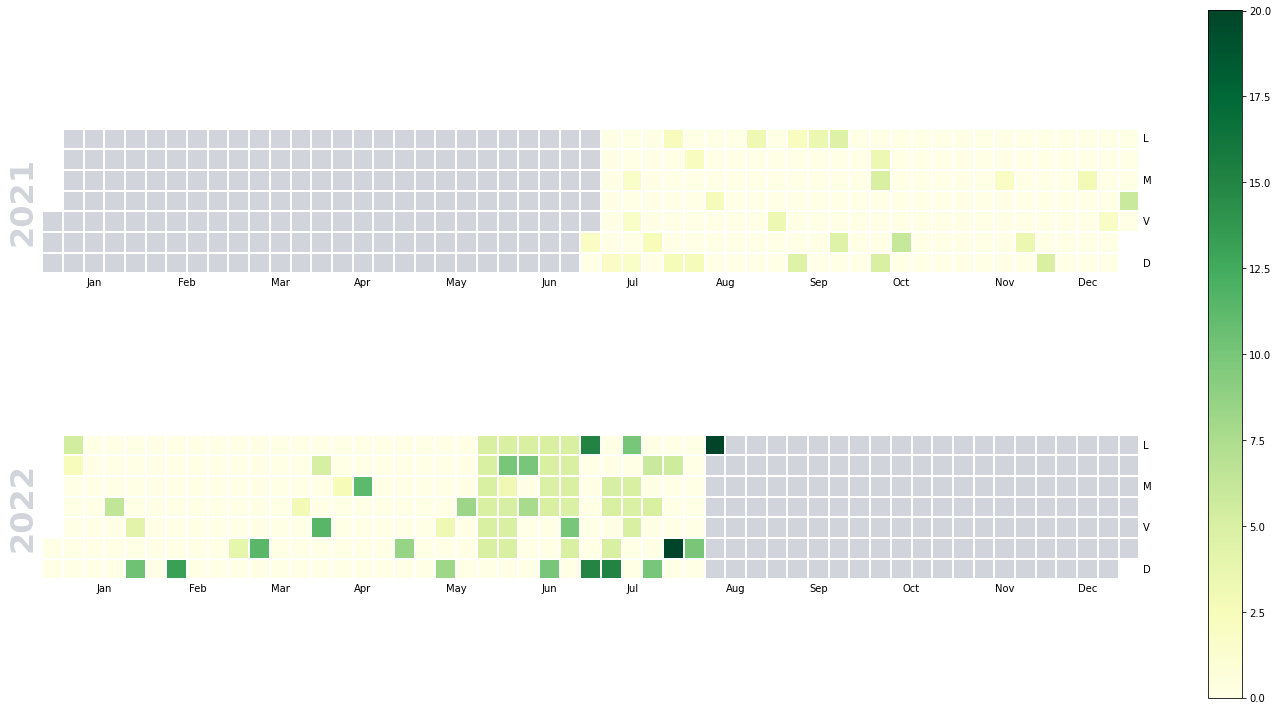

In [6]:
import calmap

sessions_calmap = sessions_df[['created_at', 'distance']].sort_values(by='created_at')
sessions_calmap = sessions_calmap.reset_index(drop=True)
sessions_calmap = pd.Series(
    sessions_calmap['distance'].tolist(),
    pd.DatetimeIndex(sessions_calmap['created_at'].tolist())
);

plt.rcParams["figure.figsize"] = (20, 10)
fig,ax = calmap.calendarplot(
    sessions_calmap,
    monthticks=3,
    cmap='YlGn', 
    fillcolor= colors['gray'][300],
    daylabels='LMMJVSD',
    linewidth=2,
    dayticks=[0, 2, 4, 6],
    fig_kws=dict(figsize=(20, 10))
);

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());

**conclusion** : Not only are there many more activities in 2022 but also the distance run has increased considerably

### Total distance per day

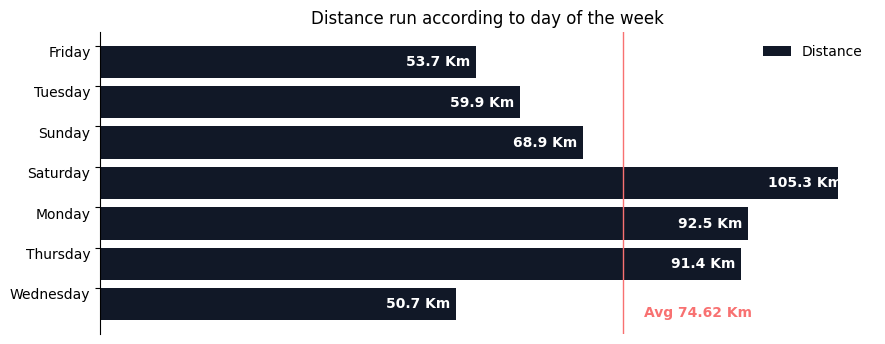

In [7]:
def repartitionPlot(x: list, y: list, title: str, label: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
    bar_width = 0.80
    ind = np.arange(len(y))
    
    average = np.average(y.tolist());
    
    ax.barh(ind, y, bar_width)
    ax.set_yticks(ind + bar_width / 2)
    ax.set_yticklabels(x, minor=False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().set_ticks([])

    plt.title(title)
    plt.rcParams['axes.titlepad'] = 30
    ax.axvline(average, color=colors['red'][400], linewidth=1)
    ax.barh(x, y, color=colors['gray'][900], label=label)
    ax.legend(frameon=False)

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')

    for i, v in enumerate(y):
        ax.text(v - 10, i - .1, str(round(v, 1)) + " Km", color='white', fontweight='bold')
        
    
    for data, xoff in zip([y.tolist()], [15, -15]):
        x0 = average
        align = 'left' if xoff > 0 else 'right'

        ax.annotate(
            'Avg {:0.2f} Km'.format(x0), 
            xy=(x0, 0), 
            xytext=(xoff, 15),
            xycoords=('data', 'axes fraction'), 
            textcoords='offset points',
            fontweight='bold',
           horizontalalignment=align, 
            verticalalignment='center',
            color=colors['red'][400],
        )
        
    plt.show();

repartitionPlot(
    x=sessions_df['weekday'].unique(), 
    y=sessions_df.groupby(sessions_df['weekday'])[['distance']].sum()['distance'], 
    title="Distance run according to day of the week", 
    label="Distance"
)

**conclusion** : Saturday is the day I run the most

### Distance progression over duration

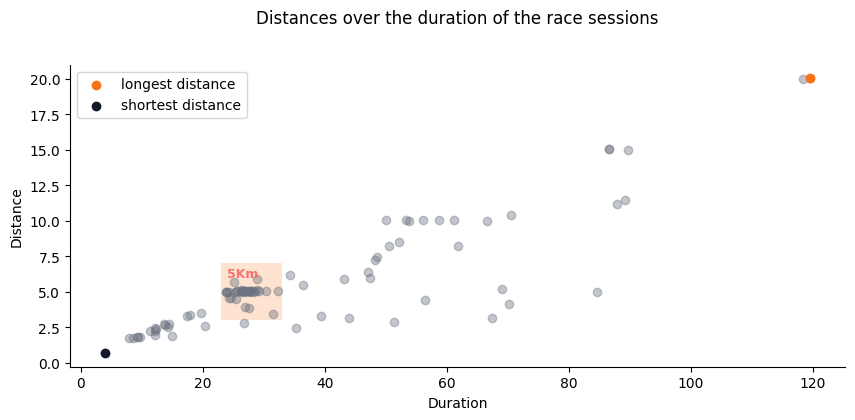

In [8]:
distances_df = sessions_df[['duration', 'distance']].sort_values(by="distance")

minimum = distances_df['distance'].min()
maximum = distances_df['distance'].max()
average = distances_df['distance'].mean()
  
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("Distances over the duration of the race sessions")
plt.xlabel("Duration")
plt.ylabel("Distance")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rectangle = mpatches.Rectangle(
    (23,3), 10,4, 
    alpha=0.2, 
    facecolor=colors['orange'][500], 
    linewidth=2
)
plt.gca().add_patch(rectangle)
plt.text(24, 6,'5Km',fontsize=9, color=colors['red'][400], weight="bold")

ax.scatter(distances_df['duration'], distances_df['distance'], color=colors['gray'][500], alpha=0.4)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == maximum], 
    maximum, 
    color=colors['orange'][500],
    label="longest distance"
)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == minimum], 
    minimum, 
    color=colors['gray'][900],
    label="shortest distance"
)
ax.legend();

**Conclusion** : The longer the distance, the longer it takes but we can also notice a certain stability for **5Km**

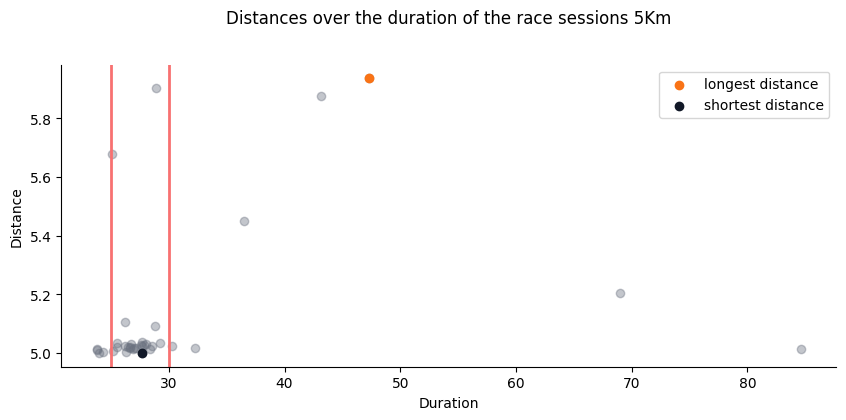

In [9]:
distances_df = sessions_df[['duration', 'distance']].sort_values(by="distance")
distances_df = distances_df.loc[distances_df['distance'] >= 5]
distances_df = distances_df.loc[distances_df['distance'] < 6].reset_index(drop=True)

minimum = distances_df['distance'].min()
maximum = distances_df['distance'].max()
average = distances_df['distance'].mean()
  
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("Distances over the duration of the race sessions 5Km")
plt.xlabel("Duration")
plt.ylabel("Distance")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axvline(25, color=colors['red'][400], linewidth=2)
ax.axvline(30, color=colors['red'][400], linewidth=2)
ax.scatter(
    distances_df['duration'], 
    distances_df['distance'], 
    color=colors['gray'][500], 
    alpha=0.4
)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == maximum], 
    maximum, 
    color=colors['orange'][500],
    label="longest distance"
)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == minimum], 
    minimum, 
    color=colors['gray'][900],
    label="shortest distance"
)
ax.legend();

**Conclusion** : The duration of a 5km race has significantly decreased over time and is now beetween 30 and 25 minutes

### Average speed progression over time

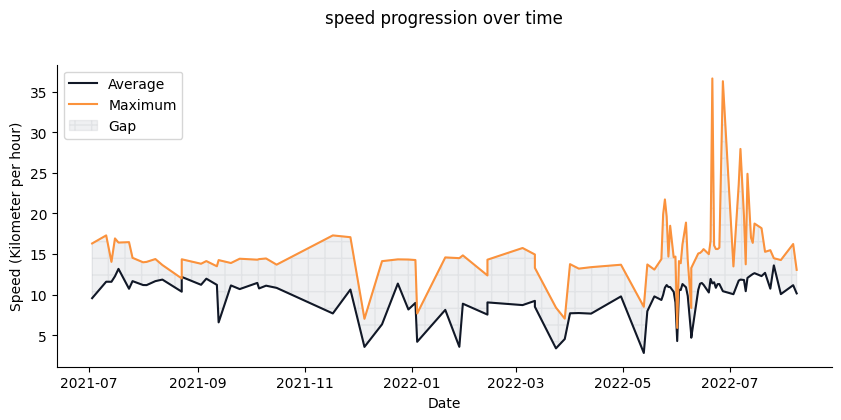

In [10]:
speed_df = sessions_df[['created_at', 'max_speed', 'average_speed']].sort_values(by='created_at')
speed_df = speed_df.reset_index(drop=True)
speed_df = speed_df[speed_df['created_at'] > dt.date(2021, 1, 1)]

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("speed progression over time")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Date")
plt.ylabel("Speed (Kilometer per hour)")

ax.plot(
    speed_df['created_at'], 
    speed_df['average_speed'], 
    color=colors['gray'][900],
    label="Average"
)
ax.plot(
    speed_df['created_at'], 
    speed_df['max_speed'], 
    color=colors['orange'][400],
    label="Maximum",
    linestyle="-"
)
ax.fill_between(
    speed_df['created_at'], 
    speed_df['average_speed'],
    speed_df['max_speed'],
    color=colors['gray'][500], 
    alpha=0.1,
    hatch="+",
    label="Gap"
)

ax.legend();
plt.show();

### Number of steps according to the distance covered

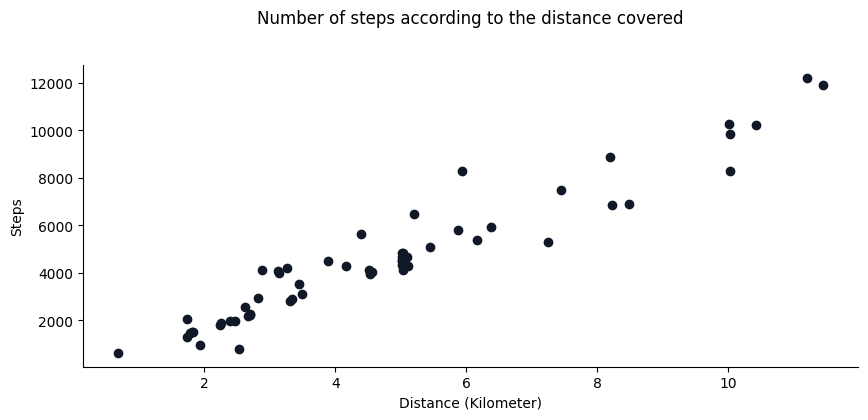

In [11]:
speed_df = sessions_df[['created_at', 'max_speed', 'total_steps', 'distance']].sort_values(by='created_at')
speed_df = speed_df.reset_index(drop=True)
speed_df = speed_df[speed_df['created_at'] > dt.date(2021, 1, 1)]

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("Number of steps according to the distance covered")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Distance (Kilometer)")
plt.ylabel("Steps")

ax.scatter(
    speed_df['distance'], 
    speed_df['total_steps'], 
    color=colors['gray'][900],
);

### Temperatures during running sessions

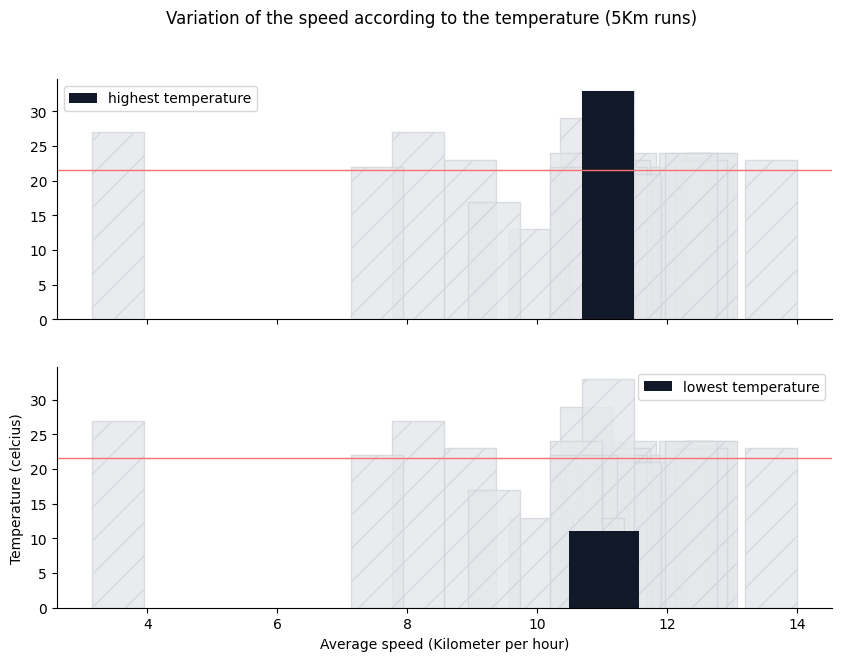

In [12]:
temperature_df = sessions_df[sessions_df['created_at'] > dt.date(2021, 1, 1)]
temperature_df = temperature_df[['distance', 'duration', 'temperature', 'average_speed']].dropna()
temperature_df = temperature_df.loc[temperature_df['distance'] >= 5]
temperature_df = temperature_df.loc[temperature_df['distance'] < 6].reset_index(drop=True)

minimum = temperature_df['temperature'].min()
maximum = temperature_df['temperature'].max()
average = temperature_df['temperature'].mean()

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Variation of the speed according to the temperature (5Km runs)")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("Average speed (Kilometer per hour)")
plt.ylabel("Temperature (celcius)")

axs[0].bar(
    temperature_df['average_speed'],
    temperature_df['temperature'],
    color=colors['gray'][200],
    hatch="/",
    edgecolor=colors['gray'][300],
    alpha=0.8
);
axs[0].bar(
    temperature_df['average_speed'][temperature_df['temperature'] == maximum], 
    maximum, 
    color=colors['gray'][900],
    label="highest temperature",
)

axs[1].bar(
    temperature_df['average_speed'],
    temperature_df['temperature'],
    color=colors['gray'][200],
    hatch="/",
    edgecolor=colors['gray'][300],
    alpha=0.8
);
axs[1].bar(
    temperature_df['average_speed'][temperature_df['temperature'] == minimum], 
    minimum, 
    color=colors['gray'][900],
    label="lowest temperature",
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(average, color=colors['red'][400], linewidth=1)
    ax.legend();

### Elevation gain and loss over time

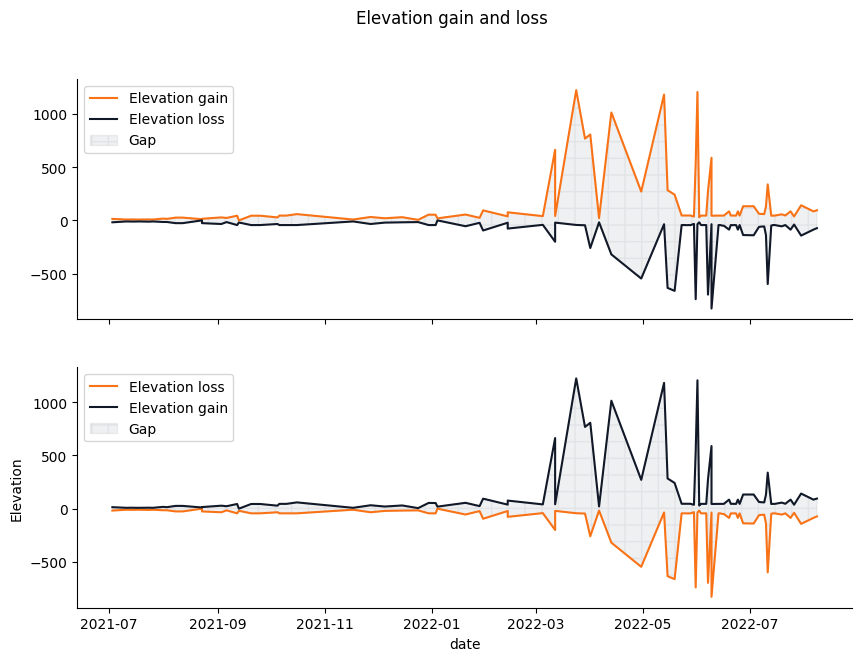

In [13]:
elevation_df = sessions_df[['created_at', 'elevation_gain', 'elevation_loss', 'distance']].sort_values(by='created_at')
elevation_df = elevation_df.reset_index(drop=True)
elevation_df = elevation_df[elevation_df['created_at'] > dt.date(2021, 1, 1)]

minimum = elevation_df['elevation_gain'].min()
maximum = elevation_df['elevation_gain'].max()
average = elevation_df['elevation_gain'].mean()

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Elevation gain and loss")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("date")
plt.ylabel("Elevation")

axs[0].plot(
    elevation_df['created_at'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[0].plot(
    elevation_df['created_at'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['created_at'],
    elevation_df['elevation_loss'],
    color=colors['orange'][500],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['created_at'],
    elevation_df['elevation_gain'],
    color=colors['gray'][900],
    label="Elevation gain"
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    ax.fill_between(
        elevation_df['created_at'], 
        elevation_df['elevation_loss'],
        elevation_df['elevation_gain'],
        color=colors['gray'][500], 
        alpha=0.1,
        hatch="+",
        label="Gap"
    )
    ax.legend();

### Elevation gain and lost on 5km runs

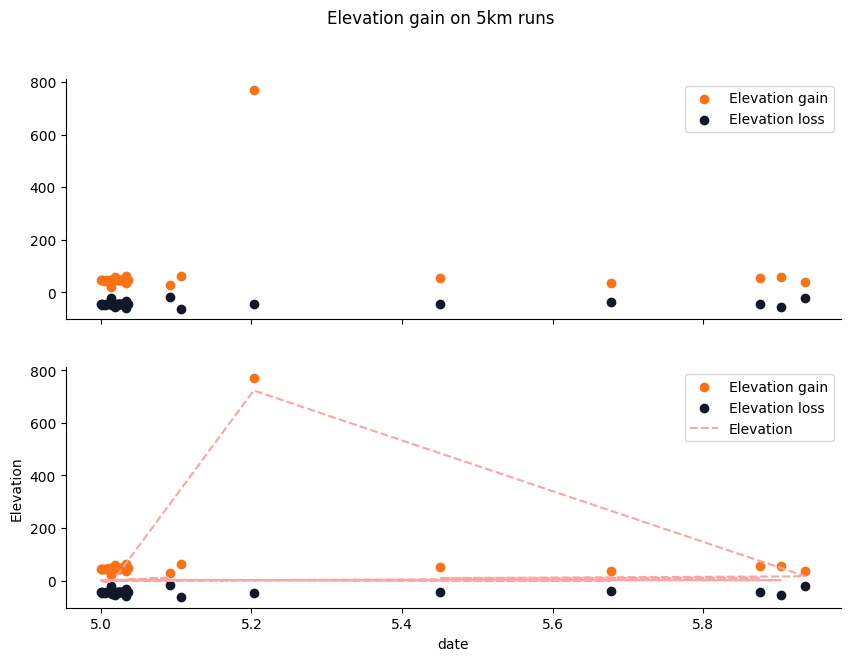

In [14]:
elevation_df = sessions_df[['created_at', 'elevation_gain', 'elevation_loss', 'distance', 'elevation']].sort_values(by='created_at')
elevation_df = elevation_df.loc[elevation_df['distance'] >= 5]
elevation_df = elevation_df.loc[elevation_df['distance'] < 6].reset_index(drop=True)

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Elevation gain on 5km runs")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("date")
plt.ylabel("Elevation")

axs[0].scatter(
    elevation_df['distance'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[0].scatter(
    elevation_df['distance'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].scatter(
    elevation_df['distance'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[1].scatter(
    elevation_df['distance'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['distance'],
    elevation_df['elevation'],
    color=colors['red'][300],
    label="Elevation",
    linestyle="--"
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    ax.legend();